# 4 - Construindo um LLM do Zero: criando significado com Embeddings

Este é o **quarto** de uma série de oito artigos que podem ser encontrados no meu medium. Acesse o primeiro artigo da série aqui: [Construindo um LLM: entendendo os Grandes Modelos de Linguagem](https://blog.zfab.me/construindo-um-llm-entendendo-os-grandes-modelos-de-linguagem-b37884219eaa)

--

Imagine estar em uma sala cheia de pessoas conversando simultaneamente. Naturalmente, seu cérebro consegue focar na voz da pessoa com quem você está falando, dando mais atenção a ela do que às outras conversas ao redor. É exatamente assim que o mecanismo de atenção funciona em modelos de linguagem — ele permite que o modelo foque em diferentes partes do texto com diferentes níveis de importância, criando uma compreensão mais profunda e contextualizada das relações entre as palavras.

In [245]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt

O mecanismo de atenção foi desenvolvido para resolver uma limitação crucial das redes recorrentes (RNNs): o esquecimento gradual das informações inseridas no modelo. Para entender melhor esse problema, vamos analisar um caso clássico de uso dessa solução: a tradução.

Imagine que queremos desenvolver um modelo que recebe uma frase em português e a traduz para o inglês. Para isso, é comum separarmos a rede em dois módulos: o **encoder** e o **decoder**. O encoder recebe o texto completo de entrada de forma sequencial e o codifica, passo a passo, em algo que chamamos de **estado oculto**. Em seguida, o decoder recebe o último estado oculto criado e começa a gerar o texto traduzido.

Podemos entender esse estado oculto como um vetor de embedding que contém todo o conteúdo e significado da frase codificados.

![](../assets/4-SEQ2SEQ.png)

Como o decoder tem acesso apenas ao último estado oculto criado, o conteúdo e significado das palavras iniciais tendem a perder relevância no vetor do estado oculto à medida que a sequência codificada se torna mais longa.

Para tentar contornar esse problema, em 2014 foi introduzido nas RNNs o mecanismo de atenção de Bahdanau, em homenagem ao seu criador. Este mecanismo permitiu que o decoder tivesse acesso a todos os estados ocultos gerados pelo encoder, não apenas ao último, atribuindo diferentes pesos de importância para cada estado durante a geração da tradução. Assim, o modelo podia "prestar atenção" em diferentes partes da sequência de entrada conforme necessário. 

Apesar de solucionar parcialmente o problema do esquecimento nas RNNs, o mecanismo de atenção de Bahdanau ainda apresentava limitações significativas, principalmente em termos de escalabilidade e processamento paralelo.

Três anos depois, em 2017, pesquisadores demonstraram que a arquitetura RNN era desnecessária e que o Mecanismo de Atenção, por si só, era suficiente para solucionar o problema da tradução — daí o título "Attention is all you need" e a introdução dos Transformers.

---

# Mecanismo de Auto Atenção

Ao ler um texto, quando você vê uma palavra, seu cérebro automaticamente a conecta com outras palavras importantes na frase. O mecanismo de Auto Atenção faz exatamente isso nos Transformers.

Diferente do sistema de atenção original (criado por Bahdanau), que apenas comparava duas frases distintas, a Auto Atenção analisa como cada palavra se relaciona com todas as outras palavras **do mesmo texto**.

Por exemplo, quando o modelo lê uma palavra, ele atribui "notas" (chamadas de pesos de atenção) para indicar a importância das outras palavras na compreensão daquela palavra específica. É como quando você lê "o cachorro pegou sua bola" - você naturalmente associa "sua" com "cachorro" para entender quem é o dono da bola.

Para entender melhor, vamos codificar um mecanismo de atenção simples. Usaremos a frase "Atenção é tudo o que precisamos", considerando cada palavra como um token representado por um embedding de 3 dimensões. 

O mecanismo de auto atenção recebe o embedding como entrada e devolve um vetor de contexto. Esse vetor pode ser considerado um embedding enriquecido, que contém não apenas as informações semânticas e posicionais do token, mas também suas relações com todos os outros tokens.

Vamos criar esse embedding enriquecido começando pelo token "tudo".

In [246]:
phrase = "Atenção é tudo o que precisamos"
tokens = phrase.split()

# Simulando um embedding de palavras
embeds = {
    "Atenção": torch.tensor([0.83, 0.71, 0.6]),
    "é": torch.tensor([0.15, 0.31, 0.12]),
    "tudo": torch.tensor([0.91, 0.81, 0.69]),
    "o": torch.tensor([0.11, 0.23, 0.12]),
    "que": torch.tensor([0.35, 0.41, 0.3]),
    "precisamos": torch.tensor([0.79, 0.92, 0.61])
}

inputs = torch.stack([embeds[token] for token in tokens])

query = inputs[tokens.index("tudo")]
print("Embedding do token 'tudo':", query)
print("Embedding da frase:", inputs)

Embedding do token 'tudo': tensor([0.9100, 0.8100, 0.6900])
Embedding da frase: tensor([[0.8300, 0.7100, 0.6000],
        [0.1500, 0.3100, 0.1200],
        [0.9100, 0.8100, 0.6900],
        [0.1100, 0.2300, 0.1200],
        [0.3500, 0.4100, 0.3000],
        [0.7900, 0.9200, 0.6100]])


O primeiro passo é calcular um valor intermediário, chamado Attention Score, para cada token da frase em relação ao nosso token "tudo” que estamos chamando de query. Para isso basta fazermos o produto escalar (torch.dot) entre query e todos os tokens

In [247]:
attention_scores = torch.empty(len(tokens))
for i, token in enumerate(tokens):
    attention_scores[i] = torch.dot(query, embeds[token])

print("Scores de atenção:", attention_scores)

Scores de atenção: tensor([1.7444, 0.4704, 1.9603, 0.3692, 0.8576, 1.8850])


Podemos ver que, por exemplo, o score de atenção entre "tudo" e "precisamos" é de `1.8850`. Utilizamos o produto escalar entre dois vetores porque ele mensura a similaridade entre eles. Um valor grande indica alto alinhamento, ou seja, maior similaridade entre os vetores. Quanto menor o valor, menor a similaridade. É dessa forma que o mecanismo de atenção determina quanto deve "prestar atenção" em cada palavra.

Agora, com os *Scores de Atenção* calculados, precisamos normalizá-los usando a função Softmax. Esta normalização permite que a rede processe os valores de forma mais eficiente e facilita os cálculos de gradientes. O resultado são probabilidades cuja soma total é igual a 1 (100%). Após a normalização, estes scores passam a ser chamados de ***Attention Weights*** (não confundir com os pesos da rede que veremos adiante).

In [248]:
attention_weights = torch.nn.functional.softmax(attention_scores, dim=0)
print("Pesos de atenção:", attention_weights)
print("Soma dos pesos de atenção:", attention_weights.sum())

Pesos de atenção: tensor([0.2306, 0.0645, 0.2862, 0.0583, 0.0950, 0.2654])
Soma dos pesos de atenção: tensor(1.)


Com os pesos de atenção calculados estamos prontos para calcular o vetor de contexto, o nosso embedding do token “tudo” enriquecido. Para isso basta multiplicarmos os embeddings dos tokens aos respectivos pesos de atenção. Ao final somamos os vetores resultantes e obtemos o resultado final

In [249]:
context_vector = torch.empty(len(query))
for i, token in enumerate(tokens):
    context_vector += attention_weights[i] * embeds[token]

print("Vetor de contexto para o token 'tudo':", context_vector)
print("Embedding anterior do token 'tudo':", embeds["tudo"])

Vetor de contexto para o token 'tudo': tensor([0.7108, 0.7121, 0.5410])
Embedding anterior do token 'tudo': tensor([0.9100, 0.8100, 0.6900])


Agora que temos o vetor contextual para o token 'tudo', precisamos aplicar o mesmo processo aos demais tokens. O código a seguir executa o mesmo procedimento, mas em vez de usar for loops, aproveitamos os cálculos matriciais para tornar o processo mais eficiente.

In [250]:
attention_scores_all = inputs @ inputs.T
attention_weights_all = torch.nn.functional.softmax(attention_scores_all, dim=-1)
context_vector_all = attention_weights_all @ inputs

print("Scores de atenção entre todos os tokens:")
print(attention_scores_all)

print("\nPesos de atenção entre todos os tokens:")
print(attention_weights_all)

print("\nVetor de contexto para todos os tokens:")
print(context_vector_all)

Scores de atenção entre todos os tokens:
tensor([[1.5530, 0.4166, 1.7444, 0.3266, 0.7616, 1.6749],
        [0.4166, 0.1330, 0.4704, 0.1022, 0.2156, 0.4769],
        [1.7444, 0.4704, 1.9603, 0.3692, 0.8576, 1.8850],
        [0.3266, 0.1022, 0.3692, 0.0794, 0.1688, 0.3717],
        [0.7616, 0.2156, 0.8576, 0.1688, 0.3806, 0.8367],
        [1.6749, 0.4769, 1.8850, 0.3717, 0.8367, 1.8426]])

Pesos de atenção entre todos os tokens:
tensor([[0.2269, 0.0728, 0.2747, 0.0665, 0.1028, 0.2563],
        [0.1845, 0.1390, 0.1947, 0.1348, 0.1509, 0.1960],
        [0.2306, 0.0645, 0.2862, 0.0583, 0.0950, 0.2654],
        [0.1810, 0.1446, 0.1889, 0.1414, 0.1546, 0.1894],
        [0.2002, 0.1160, 0.2204, 0.1107, 0.1368, 0.2159],
        [0.2261, 0.0682, 0.2790, 0.0614, 0.0978, 0.2674]])

Vetor de contexto para todos os tokens:
tensor([[0.6949, 0.6994, 0.5295],
        [0.5738, 0.6051, 0.4428],
        [0.7108, 0.7121, 0.5410],
        [0.5632, 0.5966, 0.4352],
        [0.6148, 0.6368, 0.4721],
        [

Se observarmos o terceiro vetor contextual, percebemos que os valores são os mesmos que calculamos anteriormente, demonstrando que através dos cálculos matriciais conseguimos os mesmos resultados, porém de forma mais eficiente.

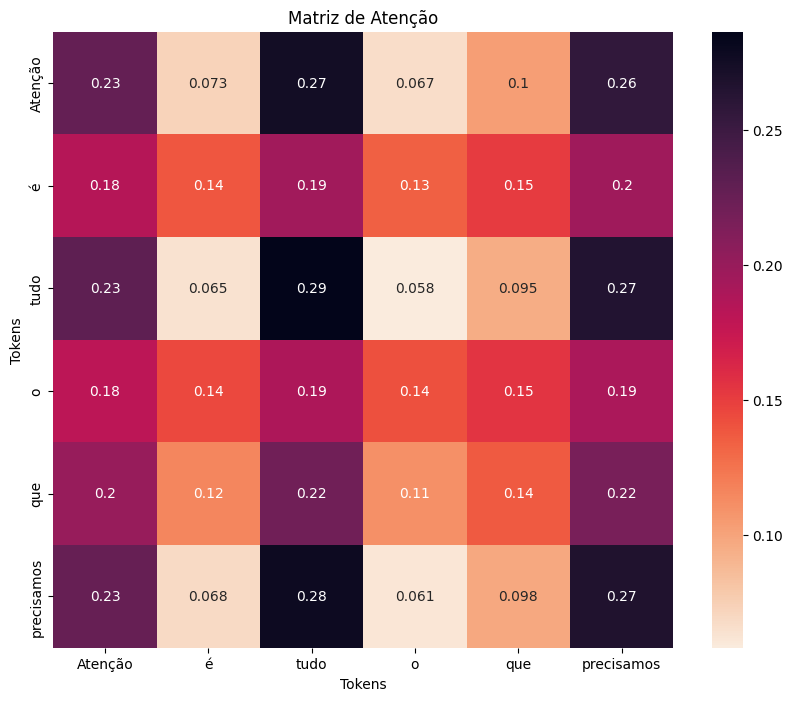

In [251]:
plt.figure(figsize=(10, 8))
sns.heatmap(attention_weights_all.detach().numpy(), annot=True, cmap='rocket_r', xticklabels=tokens, yticklabels=tokens)
plt.title('Matriz de Atenção')
plt.xlabel('Tokens')
plt.ylabel('Tokens')
plt.show()

# Treinamento da Autoatenção

A estrutura que vimos anteriormente funciona porém ainda é muito simples e não é capaz de melhorar durante o treinamento (já que não temos nenhum parâmetro ajustável). Para gerar melhores vetores contextuais, precisamos modificar levemente a estrutura do mecanismo de atenção. A estrutura que implementaremos, introduzida no paper original dos Transformers, é conhecida como *scaled dot-product attention*.

A principal diferença é que introduziremos matrizes de pesos que serão ajustados durante o treinamento e servirão para **projetar os embeddings de entrada em um novo espaço amostral**. Assim, o modelo aprenderá os melhores ajustes para capturar as nuances do contexto de entrada e gerar vetores contextuais mais precisos. 

Em vez de usar diretamente os embeddings originais dos tokens, como fizemos antes, vamos criar três novas representações a partir de cada embedding de entrada. Essas novas representações são chamadas de **query**, **key** e **value**. Para criar cada uma delas, multiplicamos o embedding original por diferentes matrizes de pesos ($w_{query}$, $w_{key}$ e  $w_{value}$) que o modelo aprenderá durante o treinamento

![](../assets/4-DIAGRAMAATENCAO.png)

Antes de implementar o mecanismo de atenção completo vamos novamente calcular a atenção para o token “tudo” da frase "Atenção é tudo o que precisamos" como exemplo.

In [252]:
x2 = inputs[tokens.index("tudo")]   # Recuperando o embedding do token "tudo" (Shape: [1,3])
d_in = x2.size(0)                   # Dimensão do embedding (Shape: 3)
d_out = d_in                        # Dimensão da projeção (Shape: 3)

torch.manual_seed(42)
W_query = torch.nn.Linear(d_in, d_out, bias=False)
W_key = torch.nn.Linear(d_in, d_out, bias=False)
W_value = torch.nn.Linear(d_in, d_out, bias=False)

Vale ressaltar que `d_out` é a dimensão do espaço vetorial para onde projetaremos nossos “embeddings”. Neste exemplo, mantivemos a mesma dimensão do embedding original (3), o que costuma ser o comum em modelos como GPT.

Para criar as matrizes de pesos, usamos uma camada Linear do PyTorch sem bias (termo de viés). Sem o bias, essa camada atua como uma matriz de pesos que multiplica os vetores de entrada para gerar novos vetores. A vantagem de usar uma camada linear é que o PyTorch oferece uma inicialização otimizada dos pesos e acelera os cálculos de backpropagation.

Com as camadas de peso criadas, podemos gerar nossos “embeddings” **query** (apenas do token 'tudo’), **key** e **values** (de todos os tokens)

In [253]:
query_x2 = W_query(x2)         # "Embedding Query" do token 'tudo' (Shape: [1,3])

keys = W_key(inputs)           # "Embeddings Key" de TODOS tokens  (Shape: [6,3])
values = W_value(inputs)       # "Embeddings Value" de TODOS tokens (Shape: [6,3])

print("\nEmbedding Query do token 'tudo':")
print(query_x2)
print("\nEmbeddings Key de todos os tokens:")
print(keys)
print("\nEmbeddings Value de todos os tokens:")
print(values)


Embedding Query do token 'tudo':
tensor([0.6965, 0.4606, 0.3700], grad_fn=<SqueezeBackward4>)

Embeddings Key de todos os tokens:
tensor([[0.0696, 0.5766, 0.2995],
        [0.1050, 0.1216, 0.1360],
        [0.0956, 0.6436, 0.3452],
        [0.0818, 0.0983, 0.1036],
        [0.0899, 0.2649, 0.1795],
        [0.1930, 0.5787, 0.3971]], grad_fn=<MmBackward0>)

Embeddings Value de todos os tokens:
tensor([[-0.2788,  0.0071, -0.6651],
        [-0.0267, -0.0369, -0.1704],
        [-0.3096,  0.0127, -0.7428],
        [-0.0277, -0.0154, -0.1309],
        [-0.1138, -0.0049, -0.3175],
        [-0.2398, -0.0356, -0.7044]], grad_fn=<MmBackward0>)


Agora que temos nossos “embeddings”, podemos calcular os Scores de Atenção. Para obter os Attention Scores, multiplicamos nossa query pela matriz keys (que contém os “embeddings” de todos os tokens). O resultado será um vetor de 6 dimensões (correspondente ao número de tokens da nossa frase), onde cada dimensão representa um score de atenção. 

In [254]:
attention_scores = query_x2 @ keys.T # Calculando os scores de atenção (Shape: [1,6])

print("\nScores de atenção entre o token 'tudo' e TODOS os tokens:")
print(attention_scores)


Scores de atenção entre o token 'tudo' e TODOS os tokens:
tensor([0.4249, 0.1795, 0.4907, 0.1406, 0.2511, 0.5479],
       grad_fn=<SqueezeBackward4>)


Finalmente podemos calcular os pesos de atenção. Dessa vez, antes de passarmos os *Scores de Atenção* pela função softmax vamos normaliza-los dividindo todos pela raiz quadrada do tamanho do embedding **key.**

Quando os *Scores de Atenção* são muito elevados, a função softmax pode gerar **gradientes extremamente pequenos** durante o backpropagation. Isso faz com que ela funcione quase como uma função binária, atribuindo aproximadamente 1 para um valor e 0 para todos os outros, o que prejudica o treinamento. Para evitar esse problema, normalizamos os valores pela raiz quadrada da dimensão do embedding, mantendo-os em uma escala mais adequada e permitindo um treinamento mais estável e eficiente.

In [255]:
attention_weights = torch.nn.functional.softmax(
    attention_scores / keys.size(-1)**0.5,          # Normalizando os scores de atenção
    dim=-1
)

print("\nPesos de atenção entre o token 'tudo' e TODOS os tokens:")
print(attention_weights)
print("Soma dos pesos de atenção:", attention_weights.sum().item())


Pesos de atenção entre o token 'tudo' e TODOS os tokens:
tensor([0.1744, 0.1514, 0.1812, 0.1480, 0.1578, 0.1873],
       grad_fn=<SoftmaxBackward0>)
Soma dos pesos de atenção: 1.0


Por fim, calculamos o vetor contextual para o token 'tudo'. Para isso, multiplicamos os pesos de atenção pelo embedding values, que é o único componente que ainda não havíamos utilizado

In [256]:
context_vector = attention_weights @ values

print("\nVetor de contexto para o token 'tudo':", context_vector)
print("Embedding anterior do token 'tudo':", embeds["tudo"])


Vetor de contexto para o token 'tudo': tensor([-0.1757, -0.0118, -0.4777], grad_fn=<SqueezeBackward4>)
Embedding anterior do token 'tudo': tensor([0.9100, 0.8100, 0.6900])


Pronto, utilizando esse processo de cálculo, conseguimos obter embeddings contextualizados e permitir que a rede aprenda, durante o treinamento, através das matrizes de peso $w$, como criar relações entre tokens e "prestar atenção". Ao final, todo esse processo pode ser resumida na equação que vemos no [paper](https://arxiv.org/pdf/1706.03762):

$$

\text{Atenção}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
$$

Com todo esse conhecimento, podemos agora criar uma classe que executa esses cálculos de forma eficiente para qualquer entrada que recebermos

In [257]:
class SelfAttention(torch.nn.Module):

    def __init__(self, d_in, d_out, qkv_bias=False):
        super().__init__()

        self.W_query = torch.nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = torch.nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = torch.nn.Linear(d_in, d_out, bias=qkv_bias)

    def forward(self, x):
        query = self.W_query(x)
        keys = self.W_key(x)
        values = self.W_value(x)

        attention_scores = query @ keys.T
        attention_weights = torch.softmax(
            attention_scores / keys.size(-1)**0.5,
            dim=-1
        )

        context_vector = attention_weights @ values

        return context_vector

Com a classe criada, podemos passar nosso input (os embeddings dos tokens da nossa frase) e receber esses embeddings agora enriquecidos — não apenas com a informação semântica e posicional, mas também contextualizados em relação à frase como um todo.

In [258]:
torch.manual_seed(42)
sa = SelfAttention(d_in, d_out, qkv_bias=False)
context_vector = sa(inputs)

print("\nVetor de contexto para o token 'tudo':")
print(context_vector)


Vetor de contexto para o token 'tudo':
tensor([[-0.1747, -0.0118, -0.4754],
        [-0.1678, -0.0121, -0.4594],
        [-0.1757, -0.0118, -0.4777],
        [-0.1675, -0.0121, -0.4586],
        [-0.1701, -0.0120, -0.4645],
        [-0.1747, -0.0119, -0.4754]], grad_fn=<MmBackward0>)


Podemos ver que o terceiro embedding, correspondente ao token 'tudo', apresenta o mesmo valor que tínhamos obtido no cálculo passo a passo anterior (`-0.1757, -0.0118, -0.4777`).

Nosso módulo de atenção está funcionando bem, mas possui uma limitação importante: nosso LLM deveria se basear exclusivamente nos tokens anteriores ao fazer previsões — nunca nos tokens futuros. Se permitíssemos isso, cometeríamos um erro semelhante ao data leakage, usando informações do alvo para prever o próprio alvo.

Para contornar esse problema, implementaremos a atenção causal

# Atenção Causal

A atenção causal, também conhecida como atenção mascarada (*masked attention*), é um tipo específico do mecanismo de atenção que limita o fluxo de informação. Durante o cálculo dos *Scores de Atenção*, ela permite que o modelo considere apenas os tokens anteriores e o atual, bloqueando completamente o acesso aos tokens futuros. Essa restrição previne o problema de leakage mencionado anteriormente.

Para implementar a atenção causal, utilizamos uma matriz triangular inferior e atribuímos o valor negativo infinito (-inf) aos Scores de Atenção acima da diagonal principal. Quando aplicamos a função softmax para normalização, esses valores -inf são efetivamente zerados na distribuição de probabilidade, garantindo que cada token só possa "prestar atenção" aos tokens anteriores e a si mesmo, mantendo a soma dos pesos de atenção igual a 1 para cada posição.

Vamos gerar uma matriz de Scores de Atenção para exemplificar a implementação

In [259]:
queries = sa.W_query(inputs)
keys = sa.W_key(inputs)

attention_scores = queries @ keys.T

mask = torch.triu(torch.ones(inputs.size(0), inputs.size(0)), diagonal=1)
masked_attention_scores = attention_scores.masked_fill(mask.bool(), float('-inf'))

print("\nScores de atenção entre todos os tokens:")
print(attention_scores)

print("\nScores de atenção mascarado:")
print(masked_attention_scores)


Scores de atenção entre todos os tokens:
tensor([[0.3796, 0.1593, 0.4383, 0.1249, 0.2237, 0.4882],
        [0.0823, 0.0443, 0.0968, 0.0344, 0.0545, 0.1190],
        [0.4249, 0.1795, 0.4907, 0.1406, 0.2511, 0.5479],
        [0.0672, 0.0349, 0.0788, 0.0271, 0.0437, 0.0955],
        [0.1768, 0.0794, 0.2050, 0.0620, 0.1073, 0.2343],
        [0.3846, 0.1741, 0.4463, 0.1361, 0.2344, 0.5117]],
       grad_fn=<MmBackward0>)

Scores de atenção mascarado:
tensor([[0.3796,   -inf,   -inf,   -inf,   -inf,   -inf],
        [0.0823, 0.0443,   -inf,   -inf,   -inf,   -inf],
        [0.4249, 0.1795, 0.4907,   -inf,   -inf,   -inf],
        [0.0672, 0.0349, 0.0788, 0.0271,   -inf,   -inf],
        [0.1768, 0.0794, 0.2050, 0.0620, 0.1073,   -inf],
        [0.3846, 0.1741, 0.4463, 0.1361, 0.2344, 0.5117]],
       grad_fn=<MaskedFillBackward0>)


Agora podemos normalizar os Scores de Atenção, normalizando e aplicando a softmax igual fizemos anteriormente

In [260]:
attention_weights = torch.nn.functional.softmax(
    masked_attention_scores / keys.size(-1)**0.5,
    dim=-1
)

print("\nPesos de atenção entre todos os tokens:")
print(attention_weights)
print("Soma dos pesos de atenção:", attention_weights.sum(dim=-1))


Pesos de atenção entre todos os tokens:
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5055, 0.4945, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3440, 0.2986, 0.3574, 0.0000, 0.0000, 0.0000],
        [0.2522, 0.2475, 0.2539, 0.2464, 0.0000, 0.0000],
        [0.2058, 0.1946, 0.2092, 0.1926, 0.1977, 0.0000],
        [0.1730, 0.1532, 0.1792, 0.1499, 0.1586, 0.1861]],
       grad_fn=<SoftmaxBackward0>)
Soma dos pesos de atenção: tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       grad_fn=<SumBackward1>)


Dessa forma, podemos observar que o modelo considera a atenção apenas para o token atual e os anteriores, nunca para os tokens futuros.

Agora vamos introduzir um novo componente muito comum em várias arquiteturas de rede e está presente também nos transformers, dentro dos mecanismos de atenção: a camada de Dropout

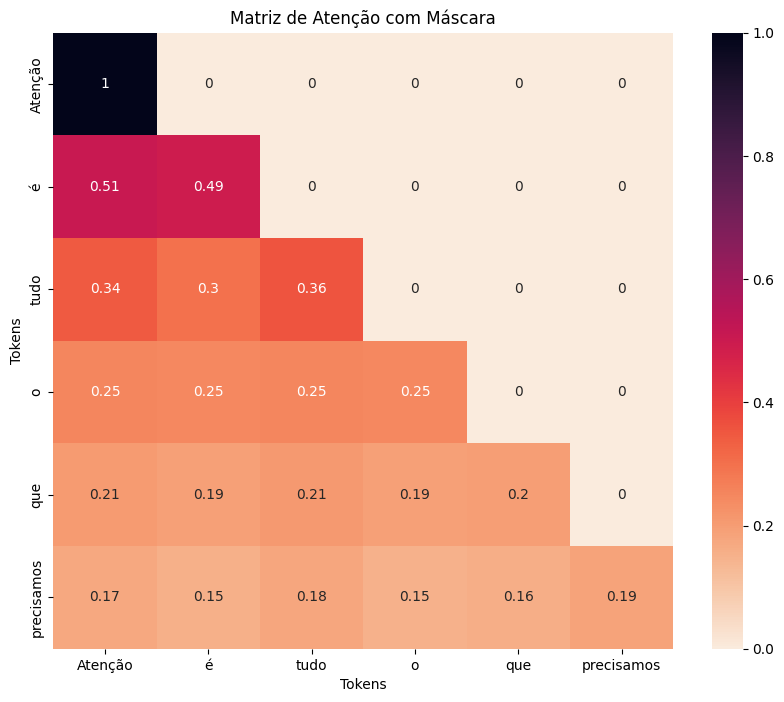

In [261]:
plt.figure(figsize=(10, 8))
sns.heatmap(attention_weights.detach().numpy(), annot=True, cmap='rocket_r', xticklabels=tokens, yticklabels=tokens)
plt.title('Matriz de Atenção com Máscara')
plt.xlabel('Tokens')
plt.ylabel('Tokens')
plt.show()

## Evitando overffiting: adicionando Dropout

O Dropout é uma técnica de regularização que desativa aleatoriamente um conjunto de neurônios durante cada etapa do treinamento. Durante o treinamento, cada neurônio tem uma probabilidade de ser temporariamente removido da rede, forçando o modelo a aprender padrões mais robustos e distribuídos.

Essa abordagem previne o overfitting ao evitar que o modelo se torne excessivamente dependente de neurônios específicos. É importante ressaltar que o Dropout é ativado apenas durante o treinamento - durante a inferência, todos os neurônios são mantidos ativos para maximizar a capacidade preditiva do modelo.

Nos modelos como o GPT, o dropout pode ser aplicado em dois pontos estratégicos do mecanismo de atenção: após o cálculo dos pesos de atenção (attention dropout) ou após o cálculo dos vetores contextuais (projection dropout). Em nossa implementação, utilizaremos o attention dropout, por ser a abordagem mais comum nas arquiteturas.

In [262]:
dropout = torch.nn.Dropout(0.5)     # Dropout com probabilidade de 50%
matriz = torch.ones(6,6)            # Matriz de 1's (Shape: [6,6])

print("Matriz original:")
print(matriz)
print("\nExemplo de dropout:")
print(dropout(matriz))


Matriz original:
tensor([[1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.]])

Exemplo de dropout:
tensor([[0., 2., 0., 0., 2., 2.],
        [0., 0., 0., 2., 0., 0.],
        [2., 2., 0., 0., 2., 2.],
        [0., 2., 0., 0., 2., 0.],
        [0., 0., 2., 2., 2., 2.],
        [0., 2., 0., 0., 0., 0.]])


No exemplo anterior, implementamos um dropout com taxa de 50%. Isso significa que, durante o treinamento, metade dos neurônios são aleatoriamente desativados (seus valores são zerados).

Para manter a magnitude dos sinais consistente na rede, os valores dos neurônios ativos são reescalados dividindo-os pelo dropout rate (que no nosso caso é 0,5). Esta compensação é necessária porque, com metade dos neurônios desativados, precisamos dobrar a intensidade dos sinais dos neurônios restantes para manter o mesmo nível de ativação total da camada.

Vamos aplicar o dropout na matriz dos pesos de atenção criada anteriormente

In [263]:
torch.manual_seed(42)
attention_weights_with_dropout = dropout(attention_weights)

print("\nPesos de atenção sem dropout:")
print(attention_weights)
print("Pesos de atenção com dropout:")
print(attention_weights_with_dropout)


Pesos de atenção sem dropout:
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5055, 0.4945, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3440, 0.2986, 0.3574, 0.0000, 0.0000, 0.0000],
        [0.2522, 0.2475, 0.2539, 0.2464, 0.0000, 0.0000],
        [0.2058, 0.1946, 0.2092, 0.1926, 0.1977, 0.0000],
        [0.1730, 0.1532, 0.1792, 0.1499, 0.1586, 0.1861]],
       grad_fn=<SoftmaxBackward0>)
Pesos de atenção com dropout:
tensor([[2.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.7147, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.4951, 0.5077, 0.0000, 0.0000, 0.0000],
        [0.4117, 0.3892, 0.0000, 0.3853, 0.3955, 0.0000],
        [0.3459, 0.3064, 0.3585, 0.2997, 0.0000, 0.0000]],
       grad_fn=<MulBackward0>)


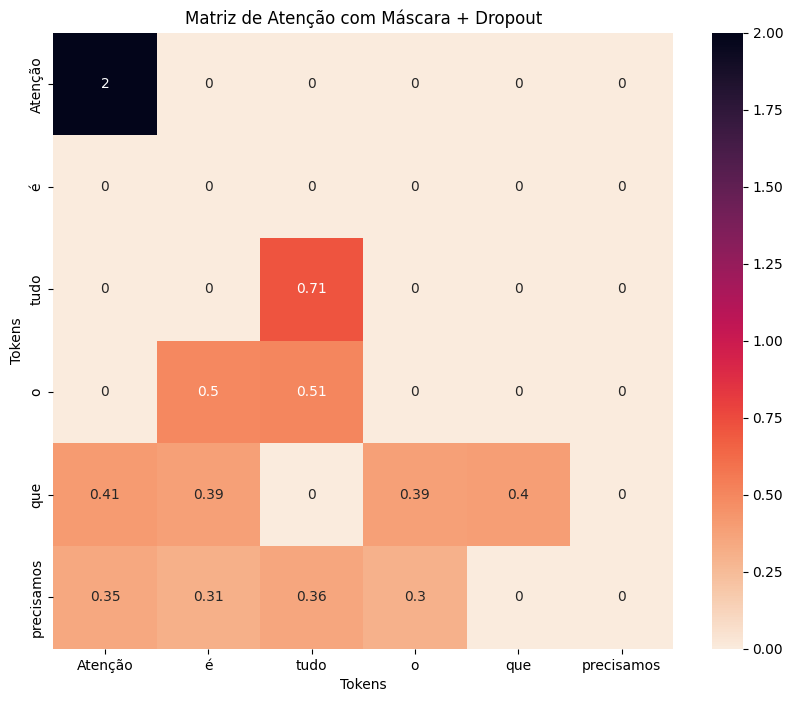

In [265]:
plt.figure(figsize=(10, 8))
sns.heatmap(attention_weights_with_dropout.detach().numpy(), annot=True, cmap='rocket_r', xticklabels=tokens, yticklabels=tokens)
plt.title('Matriz de Atenção com Máscara + Dropout')
plt.xlabel('Tokens')
plt.ylabel('Tokens')
plt.show()

Agora que o conceito do dropout e da atenção causal foram explicados vamos modificar nossa classe de atenção para incorporar esses dois mecanismos

In [108]:
class CausalAttention(torch.nn.Module):

    def __init__(self, d_in, d_out, context_length, qkv_bias=False, dropout = 0.1):
        super().__init__()

        self.W_query = torch.nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = torch.nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = torch.nn.Linear(d_in, d_out, bias=qkv_bias)

        self.dropout = torch.nn.Dropout(dropout) #1

        self.register_buffer( #2
            "mask",
            torch.triu(torch.ones(context_length, context_length), diagonal=1)
        )

    def forward(self, x):
        n_tokens, _ = x.size()

        query = self.W_query(x)
        keys = self.W_key(x)
        values = self.W_value(x)

        attention_scores = query @ keys.T
        attention_scores.masked_fill_(
            self.mask.bool()[:n_tokens, :n_tokens], -torch.inf #3
        )

        attention_weights = torch.softmax(
            attention_scores / keys.size(-1)**0.5,
            dim=-1
        )
        attention_weights = self.dropout(attention_weights) #4

        context_vector = attention_weights @ values
        return context_vector

As únicas mudanças que fizemos foram adicionar uma nova camada de dropout (1), que chamamos antes de calcular o vetor contextual, e adicionar a máscara com os valores infinitos negativos acima da diagonal principal (4).

Para criar a máscara, usamos a função `register_buffer` (2), que permite registrar um tensor como parte do estado do módulo sem que ele seja considerado um parâmetro treinável. Isso é útil para valores que precisam ser persistentes durante a execução do modelo mas não devem ser otimizados durante o treinamento, como é o caso da nossa máscara de atenção causal.

Além disso, ao aplicar a máscara à matriz de Scores de Atenção, garantimos o recorte da máscara para o tamanho equivalente ao número de tokens (3), já que nem todas as entradas terão o mesmo tamanho. Isso é particularmente importante quando processamos sequências que podem ter diferentes comprimentos (podemos ter uma frase com 4 tokens e outra com 20), garantindo que a máscara seja aplicada corretamente, independentemente do tamanho da entrada.

In [121]:
torch.manual_seed(42)
ca = CausalAttention(d_in, d_out, context_length=6, qkv_bias=False, dropout=0.2)

ca.eval() #1
context_vector = ca(inputs)

print("Vetor de contexto para TODOS tokens:")
print(context_vector)

Vetor de contexto para TODOS tokens:
tensor([[-0.2788,  0.0071, -0.6651],
        [-0.1542, -0.0146, -0.4205],
        [-0.2146, -0.0040, -0.5452],
        [-0.1624, -0.0079, -0.4307],
        [-0.1552, -0.0070, -0.4135],
        [-0.1747, -0.0119, -0.4754]], grad_fn=<MmBackward0>)


Para utilizar a classe, seguimos o mesmo procedimento anterior, com uma diferença importante: precisamos informar ao PyTorch que não estamos em modo de treinamento **(1)**, desativando assim o dropout. Sem essa configuração, o dropout continuará ativo e poderá gerar vetores contextuais zerados por conta da desativação aleatória dos neurônios.

Apesar da eficácia do nosso mecanismo de atenção atual, podemos fazer uma alteração para deixa-lo mais robusto em tarefas mais complexas. Imagine que ao invés de utilizarmos uma camada de atenção, podemos utilizar múltiplas, em paralelo, cada uma funcionando como um especialista dedicado a detectar padrões específicos nos dados de entrada.

Para ilustrar, imagine um grupo de especialistas analisando o texto. Enquanto um especialista foca nas relações entre palavras adjacentes, como artigos e substantivos outro observa conexões de média distância, como pronomes e seus referentes e um terceiro analisa o contexto global, identificando o tom e tema geral do texto.

Esta divisão de responsabilidades permite que o modelo capture desde detalhes gramaticais sutis até estruturas semânticas complexas que seriam imperceptíveis com uma única camada de atenção.

Os vetores contextuais gerados por cada "especialista" (cabeça) são combinados em um único vetor que incorpora todas essas informações, nosso vetor contextual. Essa estrutura é conhecida como Multi-Head Attention (Atenção Multi-Cabeça).

# De uma Cabeça para Muitas

O termo "multi cabeça" (multi-head) refere-se à divisão do mecanismo de atenção em múltiplas cabeças, cada uma operando de forma independente. O que implementamos anteriormente pode ser considerado como uma single-head attention, já que temos apenas um único conjunto de pesos processando os inputs.

Para implementar nossa camada *Multi-head Attention*, poderíamos criar várias instâncias da nossa classe CausalAttention e combinar seus resultados. Porém, existe uma abordagem mais eficiente: criaremos as diversas cabeças redimensionando as matrizes **query**, **key** e **value** e, após calcular a atenção, combinaremos os resultados de cada cabeça em uma única matriz

Antes de implementar uma classe que faça o calculo do Multi-Head Attention, vamos realizar os cálculos novamente passo a passo. Primeiro vamos definir nosso input, que continua sendo a frase "Atenção é tudo o que precisamos” e para cada token, criamos um “embedding” aleatório de dimensão 8

In [189]:
torch.manual_seed(42)
phrase = "Atenção é tudo o que precisamos"
tokens = phrase.split()

# Simulando um embedding de palavras
embeds = {
    "Atenção": torch.randn(8),
    "é": torch.randn(8),
    "tudo": torch.randn(8),
    "o": torch.randn(8),
    "que": torch.randn(8),
    "precisamos": torch.randn(8),
}

inputs = torch.stack([embeds[token] for token in tokens])

d_in = inputs.size(-1)      # Dimensão do embedding
d_out = d_in                # Dimensão da projeção
n_heads = 2                 # Número de cabeças de atenção
d_head = d_out // n_heads   # Dimensão da projeção em cada cabeça

W_query = torch.nn.Linear(d_in, d_out, bias=False)
W_key = torch.nn.Linear(d_in, d_out, bias=False)
W_value = torch.nn.Linear(d_in, d_out, bias=False)

out_proj = torch.nn.Linear(d_out, d_out)
mask = torch.triu(torch.ones(len(tokens), len(tokens)), diagonal=1)

Além das variáveis já conhecidas, como as matrizes de peso $w$ e a máscara triangular da atenção causal, temos `n_heads`, que define quantas cabeças de atenção teremos, e `d_head`, que determina a dimensão das matrizes **query**, **key** e **value** de cada cabeça - sendo esta dimensão o resultado da divisão das dimensões iniciais pelo número de cabeças.

Outra novidade é uma camada linear chamada `out_proj` que servirá para projetar o resultado das cabeças no nosso vetor contextual final. Pense nas múltiplas cabeças de atenção como vários especialistas e a camada linear como um "moderador", combinando as opiniões desses especialistas para produzir uma única decisão ou representação final (vetor contextual).

Agora vamos gerar as matrizes **query**, key e value multiplicando nosso input pelos respectivos pesos $w$

In [190]:
queries = W_query(inputs)
keys = W_key(inputs)
values = W_value(inputs)

print("Shape Queries:", queries.shape)
print("Shape Keys:", keys.shape)
print("Shape Values:", values.shape)

Shape Queries: torch.Size([6, 8])
Shape Keys: torch.Size([6, 8])
Shape Values: torch.Size([6, 8])


Podemos ver que as dimensões das nossas matrizes são 6 linhas, uma para cada token, e 8 valores em cada linha — os valores dos embeddings já ponderados pelos pesos $w$. Vamos agora dividir esses 8 valores entre as duas cabeças utilizando o comando `view`

In [192]:
queries = queries.view(len(tokens), n_heads, d_head)
keys = keys.view(len(tokens), n_heads, d_head)
values = values.view(len(tokens), n_heads, d_head)

print("Shape Queries:", queries.shape)
print("Shape Keys:", keys.shape)
print("Shape Values:", values.shape)

Shape Queries: torch.Size([6, 2, 4])
Shape Keys: torch.Size([6, 2, 4])
Shape Values: torch.Size([6, 2, 4])


Vemos que nossas matrizes **query**, **key** e **value** são compostas por 6 tokens, onde para cada um desses tokens temos 2 cabeças com 4 valores cada. Antes de calcular os *Scores de Atenção* e em seguida os Pesos de Atenção precisamos fazer a transposição dessas matrizes.

Precisamos reorganizar nossas matrizes de modo que os cálculos sejam feitos por cabeça e não por token. Isso é feito trocando a primeira dimensão (tokens) com a segunda dimensão (cabeças) através da operação de transposição. Dessa forma, poderemos processar as cabeças de atenção de forma independente e paralela.

In [193]:
# Transpondo as dimensões para que possamos multiplicar as matrizes corretamente (Shape esperado: [n_heads, n_tokens, d_head])
queries = queries.transpose(0, 1)
keys = keys.transpose(0, 1)
values = values.transpose(0, 1)

print("Shape Queries:", queries.shape)
print("Shape Keys:", keys.shape)
print("Shape Values:", values.shape)

Shape Queries: torch.Size([2, 6, 4])
Shape Keys: torch.Size([2, 6, 4])
Shape Values: torch.Size([2, 6, 4])


Agora os valores estão organizados na ordem correta: primeiro as cabeças, depois os tokens e, por fim, os valores individuais. Com essa estrutura, podemos calcular os Scores de Atenção e aplicar a máscara causal.

In [194]:
attention_scores = queries @ keys.transpose(-2, -1) # Fazendo a multiplicação das queries e keys transpondo as últimas duas dimensões
mask_bool = mask.bool()[:len(tokens), :len(tokens)]
attention_scores.masked_fill_(mask_bool, float('-inf'))

print("Shape Attention Scores:", attention_scores.shape)
print("\nAttention Scores:")
print(attention_scores)

Shape Attention Scores: torch.Size([2, 6, 6])

Attention Scores:
tensor([[[-0.7591,    -inf,    -inf,    -inf,    -inf,    -inf],
         [ 0.8709, -0.8787,    -inf,    -inf,    -inf,    -inf],
         [ 0.0184,  0.1349,  0.1138,    -inf,    -inf,    -inf],
         [ 0.0916,  0.1808, -0.0922, -0.0583,    -inf,    -inf],
         [-0.1927,  0.1316,  0.1359, -0.0222,  0.0728,    -inf],
         [ 0.4217, -0.5818, -0.6180, -0.0103, -0.2964, -0.4543]],

        [[-0.0480,    -inf,    -inf,    -inf,    -inf,    -inf],
         [ 0.0837,  0.7436,    -inf,    -inf,    -inf,    -inf],
         [ 0.1602, -0.4546,  1.2174,    -inf,    -inf,    -inf],
         [ 0.1047, -0.3286,  0.7837,  0.1288,    -inf,    -inf],
         [ 0.0237, -0.2529,  0.7510, -0.0975,  0.2896,    -inf],
         [-0.0731,  0.2625, -0.7685,  0.0042, -0.2592, -0.3273]]],
       grad_fn=<MaskedFillBackward0>)


Temos agora as nossas duas matrizes com os Scores de Atenção, uma para cada cabeça. Vamos achar os Pesos de Atenção

In [196]:
attention_weights = torch.nn.functional.softmax(
    attention_scores / keys.size(-1)**0.5,
    dim=-1
)

print("Shape Attention Weights:", attention_weights.shape)
print("\nAttention Weights:")
print(attention_weights)

Shape Attention Weights: torch.Size([2, 6, 6])

Attention Weights:
tensor([[[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.7057, 0.2943, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.3217, 0.3410, 0.3374, 0.0000, 0.0000, 0.0000],
         [0.2574, 0.2691, 0.2348, 0.2388, 0.0000, 0.0000],
         [0.1790, 0.2106, 0.2110, 0.1950, 0.2045, 0.0000],
         [0.2299, 0.1392, 0.1367, 0.1852, 0.1606, 0.1484]],

        [[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.4183, 0.5817, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.2914, 0.2143, 0.4943, 0.0000, 0.0000, 0.0000],
         [0.2369, 0.1907, 0.3326, 0.2397, 0.0000, 0.0000],
         [0.1854, 0.1615, 0.2668, 0.1745, 0.2118, 0.0000],
         [0.1748, 0.2068, 0.1235, 0.1817, 0.1593, 0.1540]]],
       grad_fn=<SoftmaxBackward0>)


Chegamos na última etapa: calcular os vetores contextuais.

In [198]:
context_vector = attention_weights @ values
context_vector = context_vector.transpose(0, 1) # Transpondo de volta para o formato original (Shape esperado: [n_tokens, n_heads, d_head])
context_vector = context_vector.contiguous().view(len(tokens), d_out) # Remodelando para o formato original (Shape esperado: [n_tokens, d_out])
context_vector = out_proj(context_vector)

print("Shape Vetor de Contexto:", context_vector.shape)
print("\nVetor de Contexto:")
print(context_vector)

Shape Vetor de Contexto: torch.Size([6, 8])

Vetor de Contexto:
tensor([[ 0.0257,  0.3181, -0.0296,  0.2585, -0.1248,  0.0339, -0.1693,  0.2312],
        [ 0.0084,  0.2291, -0.3647,  0.2155, -0.0515, -0.2924, -0.1800,  0.1574],
        [ 0.1803,  0.2423, -0.3487,  0.1708,  0.2053, -0.0517, -0.1429,  0.3193],
        [ 0.2501,  0.2304, -0.3660,  0.0852,  0.1882, -0.0400, -0.1757,  0.3423],
        [ 0.2623,  0.1995, -0.3935,  0.0788,  0.2488, -0.0262, -0.2089,  0.4014],
        [ 0.1728,  0.2577, -0.4239,  0.1221,  0.2583, -0.0639, -0.1834,  0.3750]],
       grad_fn=<AddmmBackward0>)


O cálculo dos vetores contextuais é feito com pequenas diferenças: após a multiplicação dos **Pesos de Atenção** com a matriz **values**, fazemos uma transposição, retornando a dimensão dos tokens para a primeira posição. Em seguida, concatenamos as cabeças usando a função `view` e, por fim, passamos o resultado pela nossa camada linear.

Agora temos nossos vetores contextuais resultantes do cálculo de múltiplas cabeças. Estamos prontos para implementar a classe que usaremos no nosso LLM

In [183]:
class MultiHeadAttention(torch.nn.Module):

    def __init__(self, d_in, d_out, context_length, n_heads, qkv_bias=False, dropout = 0.1):
        super().__init__()

        assert d_out % n_heads == 0, "d_out deve ser divisível por num_heads"

        self.d_out = d_out
        self.n_heads = n_heads
        self.d_head = d_out // n_heads

        self.W_query = torch.nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = torch.nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = torch.nn.Linear(d_in, d_out, bias=qkv_bias)

        self.out_proj = torch.nn.Linear(d_out, d_out)
        self.dropout = torch.nn.Dropout(dropout)

        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length), diagonal=1)
        )

    def forward(self, x):
        n_batch, n_tokens, _ = x.size()

        queries = self.W_query(x)
        keys = self.W_key(x)
        values = self.W_value(x)

        queries = queries.view(n_batch, n_tokens, self.n_heads, self.d_head)
        keys = keys.view(n_batch, n_tokens, self.n_heads, self.d_head)
        values = values.view(n_batch, n_tokens, self.n_heads, self.d_head)

        queries = queries.transpose(1, 2)
        keys = keys.transpose(1, 2)
        values = values.transpose(1, 2)

        attention_scores = queries @ keys.transpose(-2, -1)
        attention_scores.masked_fill_(
            self.mask.bool()[:n_tokens, :n_tokens], -torch.inf
        )

        attention_weights = torch.softmax(
            attention_scores / keys.size(-1)**0.5,
            dim=-1
        )
        attention_weights = self.dropout(attention_weights)

        context_vector = (attention_weights @ values).transpose(1, 2)
        context_vector = context_vector.contiguous().view(n_batch, n_tokens, self.d_out)
        context_vector = self.out_proj(context_vector)

        return context_vector

A classe `MultiHeadAttention` implementa exatamente o mesmo processo que fizemos anteriormente, com uma única diferença: quando formos treinar nosso LLM não enviaremos apenas uma sequência de texto e sim um conjunto de sequências (os famosos batchs). Essa técnica auxilia melhora a convergência do modelo e o tempo necessário para isso.

Por conta disso, já construímos a classe preparada para receber uma dimensão extra nos inputs: os batches. Em vez de receber apenas `[n_tokens, d_out]`, receberemos `[n_batch, n_tokens, d_out]`

In [205]:
torch.manual_seed(42)
mha = MultiHeadAttention(d_in, d_out, context_length=6, n_heads=2, qkv_bias=False, dropout=0.2)

mha.eval()
inputs_with_batch = inputs.unsqueeze(0) # Adicionando uma dimensão de batch
context_vector = mha(inputs_with_batch)

print("Vetor de contexto para TODOS tokens:")
print(context_vector.squeeze(0))

Vetor de contexto para TODOS tokens:
tensor([[ 0.4427, -0.2856,  0.6128,  0.1079,  0.6926,  0.0858,  0.3974, -0.0293],
        [ 0.2974, -0.1247,  0.4476,  0.2000,  0.6202,  0.0128,  0.3492, -0.0699],
        [ 0.2069, -0.1970,  0.1220,  0.1342,  0.2787, -0.1903,  0.2832, -0.2000],
        [ 0.1517, -0.1998,  0.0960,  0.1153,  0.2119, -0.2781,  0.3234, -0.2299],
        [ 0.1197, -0.1825,  0.0191,  0.1142,  0.1672, -0.3232,  0.3075, -0.2100],
        [ 0.0767, -0.1438,  0.0484,  0.1368,  0.2004, -0.3595,  0.3050, -0.1914]],
       grad_fn=<SqueezeBackward1>)


Com esses vetores contextuais calculados, podemos considerar nosso módulo de atenção completo!

---

# Conclusão

Neste artigo, exploramos detalhadamente o mecanismo de atenção — um componente revolucionário que transformou a maneira como os modelos de linguagem processam informações. Começamos com a arquitetura básica de atenção e avançamos até a arquitetura de múltiplas cabeças, que permite ao nosso modelo aprender relações complexas entre as palavras.

No próximo artigo, daremos um passo crucial rumo à conclusão do nosso LLM: implementaremos o bloco Transformer completo, combinando o mecanismo de atenção com feed-forward networks e normalização. Isso nos aproximará da conclusão do modelo e do início do momento mais aguardado: o pré-treinamento.